<a href="https://colab.research.google.com/github/Pawan2905/ML_Project/blob/master/jantahack_health_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# files.upload()
# !unzip Train_2.zip
# !cp Train/* ./

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *

import gc
from tqdm import tqdm, tqdm_notebook

from lightgbm import LGBMClassifier

In [ ]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('test_l0Auv8Q.csv')
health_camp = pd.read_csv('Health_Camp_Detail.csv')
camp_1 = pd.read_csv('First_Health_Camp_Attended.csv')
camp_2 = pd.read_csv('Second_Health_Camp_Attended.csv')
camp_3 = pd.read_csv('Third_Health_Camp_Attended.csv')
patient_profile = pd.read_csv('Patient_Profile.csv')
ss = pd.read_csv('sample_submmission.csv')
data_dict = pd.read_excel('Data_Dictionary.xlsx')

In [ ]:
patient_profile[['Income', 'Education_Score', 'Age']] = patient_profile[['Income', 'Education_Score', 'Age']].apply(lambda x: x.str.replace('None', 'NaN').astype('float'))
patient_profile[['City_Type',	'Employer_Category']] = patient_profile[['City_Type',	'Employer_Category']].apply(lambda x: pd.factorize(x)[0])

In [ ]:
train = pd.merge(train, patient_profile, on = 'Patient_ID', how = 'left')
test = pd.merge(test, patient_profile, on = 'Patient_ID', how = 'left')

In [ ]:
#### Getting the target

for c in [camp_1, camp_2, camp_3, train]:
  c['id'] = c['Patient_ID'].astype('str') + c['Health_Camp_ID'].astype('str')
camp_3 = camp_3[camp_3['Number_of_stall_visited'] > 0]

all_patients_in_camp = pd.Series(camp_1['id'].tolist() + camp_2['id'].tolist() + camp_3['id'].tolist()).unique()

train['target'] = 0
train.loc[train['id'].isin(all_patients_in_camp), 'target'] = 1

In [ ]:
health_camp['Category1'] = health_camp['Category1'].map({'First': 1, 'Second': 2, 'Third': 3})
health_camp['Category2'] = pd.factorize(health_camp['Category2'])[0]

health_camp['Camp_Start_Date'] = pd.to_datetime(health_camp['Camp_Start_Date'])
health_camp['Camp_End_Date'] = pd.to_datetime(health_camp['Camp_End_Date'])
health_camp['total_days_of_campaign'] = (health_camp['Camp_End_Date'] - health_camp['Camp_Start_Date']).dt.days

In [ ]:
train = pd.merge(train, health_camp, on = 'Health_Camp_ID', how = 'left')
test = pd.merge(test, health_camp, on = 'Health_Camp_ID', how = 'left')

In [ ]:
D_COL = 'Registration_Date'
for df_tmp in [train, test]:
  df_tmp[D_COL] = pd.to_datetime(df_tmp[D_COL])
test_min_date = test[D_COL].min()

In [ ]:
### Getting a train and validation split, similar to test data

trn = train[train[D_COL] < test_min_date]
val = train[train[D_COL] >= test_min_date]

In [ ]:
TARGET_COL = 'target'
features = [c for c in trn.columns if c not in ['Patient_ID', 'Health_Camp_ID', 'Registration_Date', TARGET_COL, 'id', 'Camp_Start_Date', 'Camp_End_Date', 'First_Interaction']]
len(features)

18

In [ ]:
clf = LGBMClassifier(n_estimators=550, learning_rate=0.05, random_state=1, colsample_bytree=0.5, reg_alpha=0, reg_lambda=0)

clf.fit(trn[features], trn[TARGET_COL], eval_set=[(val[features], val[TARGET_COL])], verbose=50,
        eval_metric = 'auc', early_stopping_rounds = 100)

preds = clf.predict_proba(test[features])[:, 1]

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.818497	valid_0's binary_logloss: 0.510632
[100]	valid_0's auc: 0.817272	valid_0's binary_logloss: 0.501475
Early stopping, best iteration is:
[32]	valid_0's auc: 0.821604	valid_0's binary_logloss: 0.521477


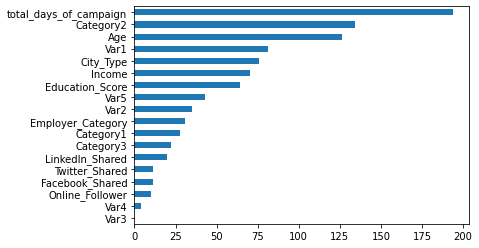

In [ ]:
fi = pd.Series(index = features, data = clf.feature_importances_)
fi.sort_values(ascending=False)[-20:][::-1].plot(kind = 'barh')

In [ ]:
ss['Outcome'] = preds
SUB_FILE_NAME = 'submission_jantahack_healthcare.csv'
ss.to_csv(SUB_FILE_NAME, index=False)
files.download(SUB_FILE_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>